In [1]:
##Preable
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
import pickle

from EightBitTransit.cTransitingImage import TransitingImage
from EightBitTransit.inversion import *
from EightBitTransit.misc import *

%matplotlib inline

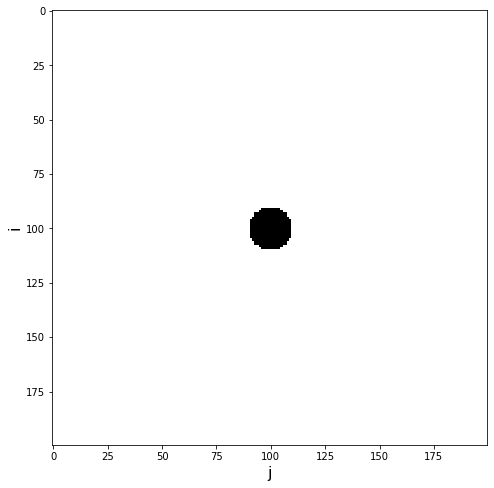

In [24]:
##Circles
fp = open("./TESSCurves/tesslc_78452879.pkl","rb") ##Loading the file
data = pickle.load(fp)
fp.close()

q = data[11]==0 #Extracting the data we want, can only keep high quality data
times = data[6][q]
planetGrid = np.zeros([200,200])

medTime = np.percentile(times, 33)
times = times - medTime

r = 0.05

for i in range(len(planetGrid)):
    for j in range(len(planetGrid[i])):
        if np.sqrt((i - len(planetGrid)/2)*(i - len(planetGrid)/2) + (j - len(planetGrid[i])/2)*(j-len(planetGrid[i])/2)) < len(planetGrid)*r:
            planetGrid[i][j] = 1
            
planet = TransitingImage(opacitymat = planetGrid, v = 14.63, t_ref = 0, t_arr = times)

planet.plot_grid()

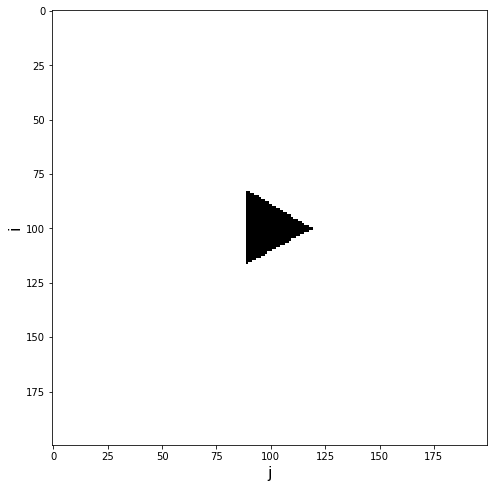

In [13]:
planetGrid = np.zeros([200,200])
times = getTimes("tesslc_364539361")

points = []
n = 3
r = 0.1
for i in range(n):
    x = int(r*len(planetGrid)*np.cos(i*2*np.pi/n + np.pi/2) + len(planetGrid)/2)
    y = int(r*len(planetGrid)*np.sin(i*2*np.pi/n + np.pi/2) + len(planetGrid)/2)
    points.append([x,y])

planetGrid = fillShape(np.zeros([200,200]),points)
            
planet = TransitingImage(opacitymat = planetGrid, v = 2, t_ref = 0, t_arr = times)

planet.plot_grid()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


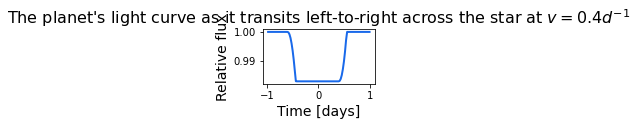

'\nfilename = input("Filename:")\n\nf = open("Signals/"+filename+".txt",\'w\')\nfor i in range(len(overlapTimes)):\n    f.write(str(overlapTimes[i]) + \'\t\' + str(planetLC[i]) + \'\n\')\n    \nf.close()\n'

In [17]:
planetLC, overlapTimes = planet.gen_LC(t_arr = times)##Generate Light Curve

fig, ax = plt.subplots(1,1,figsize=(2,1))##Plotting
ax.plot(overlapTimes,planetLC,color="#1969ea",ls="-",lw=2)
plt.xlabel("Time [days]",fontsize=14)
plt.ylabel("Relative flux",fontsize=14)
plt.title(r"The planet's light curve as it transits left-to-right across the star at $v = 0.4 d^{-1}$",fontsize=16)
plt.show()

'''
filename = input("Filename:")

f = open("Signals/"+filename+".txt",'w')
for i in range(len(overlapTimes)):
    f.write(str(overlapTimes[i]) + '\t' + str(planetLC[i]) + '\n')
    
f.close()
'''

In [2]:
def fillShape(grid,points):
    outline = np.zeros([len(grid),len(grid)])
    for i in range(len(points)):
        j = (i + 1)%len(points)
        if points[i][0] - points[j][0] != 0:
            if points[i][0] < points[j][0]:
                x1 = points[i][0]
                y1 = points[i][1]
                x2 = points[j][0]
                y2 = points[j][1]
            else:
                x1 = points[j][0]
                y1 = points[j][1]
                x2 = points[i][0]
                y2 = points[i][1]
            for k in range(x1,x2):
                y = int(((y1-y2)/(x1-x2))*(k - x1) + y1)
                outline[k][y] = 1
        else:
            if points[i][1] < points[j][1]:
                x1 = points[i][0]
                y1 = points[i][1]
                x2 = points[j][0]
                y2 = points[j][1]
            else:
                x1 = points[j][0]
                y1 = points[j][1]
                x2 = points[i][0]
                y2 = points[i][1]
            for k in range(y1,y2):
                x = int(((x1-x2)/(y1-y2))*(k - y1) + x1)
                outline[x][k] = 1
             
    for i in range(len(grid)):
        totalPasses = 0
        for j in range(len(grid)):
            passes = 0
            if outline[i][j] == 1:
                totalPasses += 1
            for k in range(j):
                if outline[i][j-k] == 1:
                    passes += 1
            if passes == 1:
                grid[i][j] = 1
        if totalPasses == 1 or totalPasses > 2:
            grid[i] = 0
    
    return grid

In [3]:
def getTimes(filename):
    fp = open("./TESSCurves/"+filename+".pkl","rb") ##Loading the file
    data = pickle.load(fp)
    fp.close()

    q = data[11]==0 #Extracting the data we want, can only keep high quality data
    times = data[6][q]
    midTime = np.percentile(times,33) ##Set the 0 point at 1/3. Eight Bit Transit centers light curves at 0 so put this where you want to center the transit
    ##Tess light curves seem to have a 2 day gap near the center
    times = times - midTime
    return times